In [105]:
%matplotlib inline
import qiskit.tools.jupyter

from qiskit import *
from qiskit.visualization import plot_circuit_layout, plot_gate_map


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl')

C:\Users\Bkama\Anaconda3\envs\qiskit-dev\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:187: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [106]:
backend = provider.get_backend('ibmq_poughkeepsie')

In [107]:
# Import the quantum volume sub-module from Ignis
import qiskit.ignis.verification.quantum_volume as qv
import matplotlib.pyplot as plt
import numpy as np

# Also import Aer's noise model functionality to allow us to compare actual performance
# to that expected from device 1Q and 2Q error rates
from qiskit.providers.aer.noise.device.models import basic_device_noise_model
from qiskit.transpiler.coupling import CouplingMap


In [108]:
def find_subgraph(size: int, backend: backend) -> list:
    """Returns a list of integers corresponding to physical qubits forming a connected subgraph
    
    Args:
        size: integer defining the number of nodes that should be in the connected subgraph
        backend: real device backend to form the subgraph on
        
    Returns:
        subgraph: list of integers, each element corresponds to one physical qubit on backend.  
                  list size should be size.
    """
    
    import numpy as np
    
    
    perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    # Setup main graph to traverse
    c_list = backend.configuration().coupling_map
    c_map = CouplingMap(c_list)
    
    while not c_map.subgraph(perm[:size]).is_connected():
        perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    return perm[:size]
    
    
    

In [109]:
find_subgraph(5, backend)

array([ 7, 12,  5,  6, 13])

In [110]:
# from timeit import default_timer as timer

# start = timer()
# for _ in range(1000):
#     find_subgraph(7, backend)
# end = timer()
# print((end - start)/1000) # Time in seconds, e.g. 5.38091952400282

In [111]:
def cleanup_matrix(mx: list, norm: float) -> np.ndarray:
    new_mx = [[int(x.real / norm) for x in row] for row in matrix]
    
    return np.array(new_mx)

In [153]:
def ibm_oracle(qc: QuantumCircuit, q: QuantumRegister) -> QuantumCircuit:
    qc.z(q)
    qc.cz(q[1],q[0])
    qc.cz(q[2],q[0])
    qc.cz(q[2],q[1])
    
    return qc

def two_oracle(qc: QuantumCircuit, q: QuantumRegister, winner: int)\
                                                -> QuantumCircuit:
    if winner == 0: 
        qc.ccx(q[0], q[1], q[2])
    elif winner == 1:
        qc.x(q[1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[1])
    elif winner == 2:
        qc.x(q[0])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[0])
    elif winner == 3:
        qc.x(q[:-1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[:-1])
    else:
        raise ValueError('Winner must be in range(4)')
    
    return qc

def three_oracle(qc: QuantumCircuit, q: QuantumRegister, winner: int)\
                                                -> QuantumCircuit:
    
    # q[3] is our work space
    
    
    if winner == 0: 
        qc.ccx(q[0], q[1], q[3])
    elif winner == 1:
        qc.x(q[1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[1])
    elif winner == 2:
        qc.x(q[0])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[0])
    elif winner == 3:
        qc.x(q[:-1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[:-1])
    else:
        raise ValueError('Winner must be in range(4)')
    
    return qc

def three_z(qc: QuantumCircuit, q: QuantumRegister) -> QuantumCircuit:
    qc.ccx(q[0], q[1], q[4])
    qc.barrier()
    qc.ccx(q[2], q[4], q[5])
    qc.barrier()
    qc.cz(q[5], q[3])
    qc.barrier()
    qc.ccx(q[2], q[4], q[5])
    qc.barrier()
    qc.ccx(q[0], q[1], q[4])
    
    return qc

def zero_inversion(qc: QuantumCircuit, q: QuantumRegister) -> QuantumCircuit:
    qc.x(q[:2])
    qc.cz(q[0], q[1])
    qc.barrier()
    qc.x(q[:2])
    
    return qc

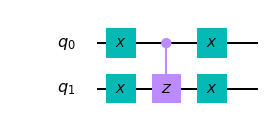

In [113]:
# Testing the straight zero inverter

q = QuantumRegister(2, 'q')
qc = QuantumCircuit(q)

qc = zero_inversion(qc, q)
qc.draw(output='mpl', plot_barriers=False)

In [114]:
unitary_sim = Aer.get_backend('unitary_simulator')
matrix = execute(qc, unitary_sim).result().get_unitary()
print(cleanup_matrix(matrix, 1))

[[-1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]]


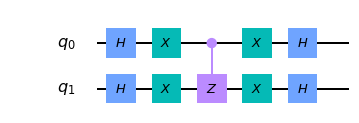

In [115]:
# Testing the inversion about the average

qc_average = QuantumCircuit(2, name='test')

qc_average.h(qc_average.qregs[0])
qc_average = zero_inversion(qc_average, qc_average.qregs[0])
qc_average.h(qc_average.qregs[0])

qc_average.draw(output='mpl', plot_barriers=False)

In [116]:
matrix = execute(qc_average, unitary_sim).result().get_unitary()
print(cleanup_matrix(matrix, .5))

[[ 1 -1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1  1 -1]
 [-1 -1 -1  1]]


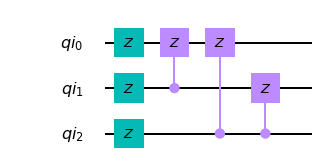

In [117]:
qri = QuantumRegister(3, 'qi')
qci = QuantumCircuit(qri, name='qci')

qci = ibm_oracle(qci, qri)

qci.draw(output='mpl')

In [118]:
matrix = execute(qci, unitary_sim).result().get_unitary()
print(cleanup_matrix(matrix, 1))

[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  1]]


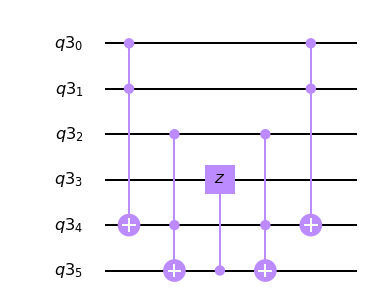

In [154]:
qr3 = QuantumRegister(6, 'q3')
qc3 = QuantumCircuit(qr3, name='qc3')

qc3 = three_z(qc3, qr3)


qc3.draw(output='mpl', plot_barriers=False)

In [156]:
import sys
import numpy


numpy.set_printoptions(threshold=sys.maxsize)

matrix = execute(qc3, unitary_sim).result().get_unitary()
print(str(cleanup_matrix(matrix, 1)).replace('\r', '').replace('\n', '').replace(']', ']\r\n'))

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  

In [145]:
# Creating a 4 bit oracle

test = QuantumRegister(4)
test_circuit = QuantumCircuit(test)

test_circuit.z(test)
# test_circuit.z(test[3])
# test_circuit.cz(test[2], test[3])
# test_circuit.cz(test[0], test[3])

matrix = execute(test_circuit, unitary_sim).result().get_unitary()
print(str(cleanup_matrix(matrix, 1)).replace('\r', '').replace('\n', '').replace(']', ']\r\n'))

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
]



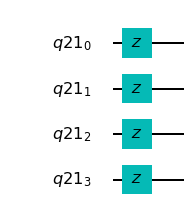

In [146]:
test_circuit.draw(output='mpl')

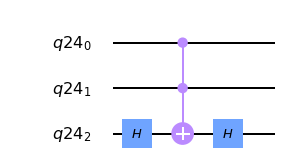

In [157]:
# Testin a two-control z to see the matrix:

qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

qc.h(qr[-1])
qc.ccx(qr[0], qr[1], qr[2])
qc.h(qr[-1])

qc.draw(output='mpl', plot_barriers=False)

In [159]:
matrix = execute(qc, unitary_sim).result().get_unitary()
print(cleanup_matrix(matrix, 1))

[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]


In [ ]:
qv_test = transpile(qc, backend, initial_layout=find_subgraph(7, backend))
plot_circuit_layout(qv_test, backend)